
---

📚 <font color='blue'> Based on tutorial
[Object Detection with TensorFlow Lite Model Maker](https://www.tensorflow.org/lite/tutorials/model_maker_object_detection)</font>

---



---

### Download model from Detection Model Zoo

Look at [Mobile models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1_detection_zoo.md#mobile-models) section, model name is `ssd_mobilenet_v3_large_coco`.

There is also model called `ssd_mobilenet_v3_small_coco` and based on this [paper](https://arxiv.org/pdf/1905.02244.pdf) the difference between `large` and `small` refers to high and low resource use cases respectively (*section 5.4 MobileNetV3 Definitions*). `Large` version contains more operations and `small` version contains less operations, as follows:
![MobileNetV3_large_vs_small.png](https://raw.githubusercontent.com/marcin-ch/Object_Detection_SSD_MobilenetV3_Large_COCO_TFLite/main/MobileNetV3_large_vs_small.png)

By default, it will be downloaded to `/content/` folder.

Corresponding notebook for `ssd_mobilenet_v3_small_coco` is available at `GoogleDrive\Object_Detection\Object_Detection_SSD_MobilenetV3_TFLite.ipynb` and [Github](https://github.com/marcin-ch/Object_Detection_SSD_MobilenetV3_TFLite).

**Code is the same, only model's path has been changed.**

---


In [1]:
!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v3_large_coco_2020_01_14.tar.gz
# !wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v3_small_coco_2020_01_14.tar.gz

--2021-09-09 11:30:40--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v3_large_coco_2020_01_14.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.23.128, 2404:6800:4008:c02::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.23.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49318766 (47M) [application/gzip]
Saving to: ‘ssd_mobilenet_v3_large_coco_2020_01_14.tar.gz’

ssd_mobilenet_v3_la 100%[===================>]  47.03M  22.2MB/s    in 2.1s    

2021-09-09 11:30:43 (22.2 MB/s) - ‘ssd_mobilenet_v3_large_coco_2020_01_14.tar.gz’ saved [49318766/49318766]




---

### Untar tar.gz file

Once it is done, you can see `*.tflite` model available at `/content/ssd_mobilenet_v3_large_coco_2020_01_14/model.tflite`

---


In [2]:
!tar -xzvf "/content/ssd_mobilenet_v3_large_coco_2020_01_14.tar.gz"
# !tar -xzvf "/content/ssd_mobilenet_v3_small_coco_2020_01_14.tar.gz"

ssd_mobilenet_v3_large_coco_2020_01_14/pipeline.config
ssd_mobilenet_v3_large_coco_2020_01_14/model.ckpt.index
ssd_mobilenet_v3_large_coco_2020_01_14/model.ckpt.data-00000-of-00001
ssd_mobilenet_v3_large_coco_2020_01_14/model.tflite
ssd_mobilenet_v3_large_coco_2020_01_14/frozen_inference_graph.pb
ssd_mobilenet_v3_large_coco_2020_01_14/checkpoint
ssd_mobilenet_v3_large_coco_2020_01_14/model.ckpt.meta
ssd_mobilenet_v3_large_coco_2020_01_14/



---

### Import required packages

---


In [3]:
import numpy as np
import os

import tensorflow as tf
assert tf.__version__.startswith('2')
print("Current TF version:", tf.__version__)

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

Current TF version: 2.6.0



---

### Load the trained TFLite model and define some visualization functions

---


In [4]:
# Load the trained TFLite model and define some visualization functions

import cv2

from PIL import Image

model_path = '/content/ssd_mobilenet_v3_large_coco_2020_01_14/model.tflite'
# model_path = '/content/ssd_mobilenet_v3_small_coco_2020_01_14/model.tflite'

# Load the labels into a list
# https://github.com/amikelive/coco-labels/blob/master/coco-labels-paper.txt
classes = ["person", "bicycle", "car", "motorcycle", "airplane", "bus", "train",
           "truck", "boat", "traffic light", "fire hydrant", "???(ID12)", "stop sign",
           "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow",
           "elephant", "bear", "zebra", "giraffe", "???(ID26)", "backpack", "umbrella",
           "???(ID29)", "???(ID30)", "handbag", "tie", "suitcase", "frisbee", "skis",
           "snowboard", "sports ball", "kite", "baseball bat", "baseball glove",
           "skateboard", "surfboard", "tennis racket", "bottle", "???(ID45)", "wine glass",
           "cup", "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich",
           "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
           "chair", "couch", "potted plant", "bed", "???(ID66)", "dining table",
           "???(ID68)", "???(ID69)", "toilet", "???(ID71)", "tv", "laptop", "mouse", "remote",
           "keyboard", "cell phone", "microwave", "oven", "toaster", "sink",
           "refrigerator", "???(ID83)", "book", "clock", "vase", "scissors",
           "teddy bear", "hair drier", "toothbrush"]

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  return resized_img, original_image


def set_input_tensor(interpreter, image):
  """Set the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Retur the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  # Feed the input image to the model
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  # Get all outputs from the model
  boxes = get_output_tensor(interpreter, 0)
  classes = get_output_tensor(interpreter, 1)
  scores = get_output_tensor(interpreter, 2)
  count = int(get_output_tensor(interpreter, 3))

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8


---

### Run object detection and show the detection results

---


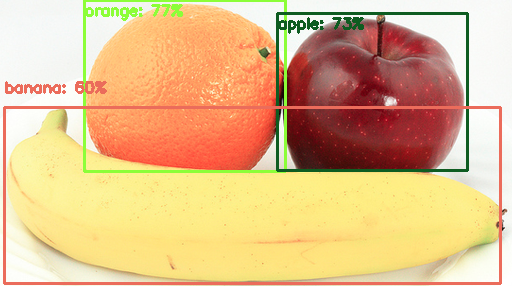

In [5]:
# Run object detection and show the detection results

# INPUT_IMAGE_URL = "https://c8.alamy.com/comp/2BYP7FK/little-girl-hugging-teddy-bear-2BYP7FK.jpg" #@param {type:"string"}
# INPUT_IMAGE_URL = "https://vw.plichta.com.pl/wp-content/uploads/2017/07/db2016au00964.jpg" #@param {type:"string"}
# INPUT_IMAGE_URL = "https://www.indianhealthyrecipes.com/wp-content/uploads/2018/09/veg-mayo-sandwich-recipe.jpg" #@param {type:"string"}
# INPUT_IMAGE_URL = "https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/apples-vs-oranges-health-benefits-1524606349.jpg" #@param {type:"string"}
INPUT_IMAGE_URL = "https://messalonskeehs.files.wordpress.com/2013/02/screen-shot-2013-02-06-at-10-50-37-pm.png" #@param {type:"string"}
# INPUT_IMAGE_URL = "https://storage.googleapis.com/cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg" #@param {type:"string"}
DETECTION_THRESHOLD =  0.45#@param {type:"number"}

TEMP_FILE = '/tmp/image.png' 

!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
im = Image.open(TEMP_FILE)
im.thumbnail((512, 512), Image.ANTIALIAS)
im.save(TEMP_FILE, 'PNG')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    TEMP_FILE,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)


---

### Read model signatures

Explanation for model input/output available [here](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/running_on_mobile_tf2.md)

```
Four Outputs:
  detection_boxes: a float32 tensor of shape [1, num_boxes, 4] with box locations
  detection_classes: a float32 tensor of shape [1, num_boxes] with class indices
  detection_scores: a float32 tensor of shape [1, num_boxes] with class scores
  num_boxes: a float32 tensor of size 1 containing the number of detected boxes
```

---


In [6]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
print("INPUT DETAILS", input_details)
output_details = interpreter.get_output_details()
print("OUTPUT DETAILS", output_details)

INPUT DETAILS [{'name': 'normalized_input_image_tensor', 'index': 422, 'shape': array([  1, 320, 320,   3], dtype=int32), 'shape_signature': array([  1, 320, 320,   3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.0078125, 128), 'quantization_parameters': {'scales': array([0.0078125], dtype=float32), 'zero_points': array([128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
OUTPUT DETAILS [{'name': 'TFLite_Detection_PostProcess', 'index': 414, 'shape': array([  1, 100,   4], dtype=int32), 'shape_signature': array([  1, 100,   4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'TFLite_Detection_PostProcess:1', 'index': 415, 'shape': array([  1, 100], dtype=int32), 'shape_signature': array([  1, 100], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quanti

In [7]:
output_shape_box_locations = output_details[0]['shape']
print("OUTPUT SHAPE - BOX LOCATIONS    ", output_shape_box_locations)
output_shape_class_indices = output_details[1]['shape']
print("OUTPUT SHAPE - CLASS INDICES    ", output_shape_class_indices)
output_shape_class_scores = output_details[2]['shape']
print("OUTPUT SHAPE - CLASS SCORES     ", output_shape_class_scores)
output_shape_detected_boxes_no = output_details[3]['shape']
print("OUTPUT SHAPE - DETECTED BOXES NO", output_shape_detected_boxes_no)

OUTPUT SHAPE - BOX LOCATIONS     [  1 100   4]
OUTPUT SHAPE - CLASS INDICES     [  1 100]
OUTPUT SHAPE - CLASS SCORES      [  1 100]
OUTPUT SHAPE - DETECTED BOXES NO [1]



---

### Get all outputs from the model

---


In [8]:
# Box locations
boxes = get_output_tensor(interpreter, 0)
print(boxes)
print(boxes.shape, boxes.dtype)

[[ 1.36592984e-03  1.64515495e-01  6.01240039e-01  5.57178438e-01]
 [ 4.54798341e-02  5.41991472e-01  5.95352232e-01  9.12610888e-01]
 [ 3.74867499e-01  9.59041715e-03  9.92398441e-01  9.77240205e-01]
 [ 6.95312023e-02  5.40591896e-01  8.88492644e-01  9.68220055e-01]
 [ 5.12316823e-03  3.28887910e-01  6.67642593e-01  9.72648501e-01]
 [ 5.59696630e-02  5.84525883e-01  2.28237152e-01  8.75470340e-01]
 [ 1.74295604e-02  1.24301493e-01  9.02758479e-01  8.00279558e-01]
 [ 1.93792164e-01  1.04603171e-03  8.38393271e-01  9.94766831e-01]
 [ 7.17570543e-01  3.39055061e-03  9.93964434e-01  1.00119102e+00]
 [ 3.65755081e-01  3.42841148e-02  9.96309519e-01  5.53778291e-01]
 [ 5.98971248e-02  5.87922454e-01  2.98426658e-01  7.59796858e-01]
 [ 1.32719487e-01  4.79962826e-02  8.00666928e-01  6.14368021e-01]
 [ 3.80207539e-01  1.99954122e-01  1.04236639e+00  7.74491668e-01]
 [ 2.09911346e-01  3.94591212e-01  5.90447426e-01  5.45587718e-01]
 [ 1.15433335e-02  1.89366341e-02  9.33214486e-01  5.15376210e

In [9]:
# Class indices
classes = get_output_tensor(interpreter, 1)
print(classes)
print(classes.shape, classes.dtype)

[54. 52. 51. 52. 52. 52. 51. 51. 50. 51. 52. 54. 51. 54. 51. 54. 52. 54.
 52. 52. 54. 52. 54. 52. 51. 52. 52. 51. 52. 52. 54. 52. 51. 54. 52. 52.
 52. 51. 52. 52. 54. 54. 52. 52. 52. 51. 52. 52. 52. 52. 52. 52. 66. 54.
 54. 54. 51. 51. 51. 52. 52. 66. 51. 51. 51. 52. 52. 54. 54. 52. 52. 52.
 52. 52. 52. 52. 51. 52. 52. 54. 52. 54. 52. 52. 52. 51. 52. 52. 52. 66.
 54. 54. 54. 52. 52. 54. 51. 52. 54. 52.]
(100,) float32


In [10]:
# Class scores
scores = get_output_tensor(interpreter, 2)
print(scores)
print(scores.shape, scores.dtype)

[0.7687732  0.7259464  0.6032472  0.23369756 0.16698822 0.15718964
 0.12981552 0.1253894  0.11693388 0.11479619 0.11174348 0.11094028
 0.10879853 0.1073114  0.1026676  0.09891433 0.09758803 0.09706679
 0.09701896 0.09648192 0.09604502 0.09574804 0.09567726 0.09453145
 0.09357944 0.09350142 0.09331936 0.09315056 0.09136033 0.08971438
 0.08735672 0.08472905 0.08350322 0.08301654 0.08096346 0.0808481
 0.07854527 0.07835835 0.07647815 0.07586232 0.07516178 0.07284114
 0.07128295 0.0710817  0.0709804  0.07075319 0.07024547 0.06748468
 0.06687871 0.06595826 0.06584042 0.06532261 0.06521508 0.06516626
 0.06515989 0.06485587 0.06431672 0.06279311 0.06241885 0.06212363
 0.05972406 0.05965039 0.05953836 0.05941635 0.05788752 0.05619964
 0.05581987 0.05571821 0.05553335 0.05527714 0.05495417 0.05495149
 0.05454254 0.05441052 0.05350336 0.05303526 0.05276448 0.05233151
 0.0521816  0.05173552 0.05156425 0.0514003  0.05093059 0.05083799
 0.05071577 0.05060977 0.05048114 0.0498378  0.04947734 0.04940

In [11]:
# Detected boxes no
count = int(get_output_tensor(interpreter, 3))
print(count)

100



---

### Final comments

Assuming
```
INPUT_IMAGE_URL = "https://messalonskeehs.files.wordpress.com/2013/02/screen-shot-2013-02-06-at-10-50-37-pm.png" #@param {type:"string"}
```
you get first three `classes` such as:<br>
`[54. 52. 51.]`,<br>
and corresponding `scores` such as:<br>
`[0.7687732  0.7259464  0.6032472]`.

Based on that and COCO labels, the results are:<br>
`54 = orange`, `52 = apple`, `51 = banana`.<br>
And confidence levels:<br>
`77% for orange`, `73% for apple`, `60% for banana` which you can see also in image. 



---



---

### `large` vs `small` comparison
Output from `small` version of MobileNetV3 was:<br>
`[54. 52. 51.]`<br>
`[0.75766706 0.7211507  0.55102885]`<br>
`76% for orange`, `72% for apple`, `55% for banana`<br>
and you can verify it at `GoogleDrive\Object_Detection\Object_Detection_SSD_MobilenetV3_TFLite.ipynb` and [Github](https://github.com/marcin-ch/Object_Detection_SSD_MobilenetV3_TFLite).

Therefore, comparing output from `large` version of MobileNetV3, seems `large` version is more confident, that image contains orange (`77% vs 76%`), apple (`73% vs 72`) and banana (`60% vs 55%`). In terms of bounding boxes, I do not see any visible difference.
